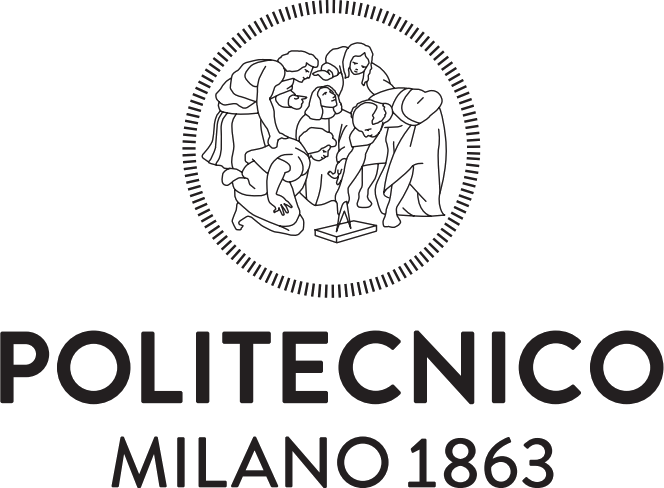

# Network Measurements and Data Analysis Lab

**Professor Alessandro Enrico Cesare Redondi**

**Moein Taherinezhad - 240265**

**Home Work No.3**




Develop an **online clustering system** for probe requests utilizing the lecture dataset. Upon receipt of a probe request, determine whether to initiate a new cluster or assign it to an existing one based on feature similarity. Membership to a cluster is granted if a minimum of N features align. In case of tiebreakers, follow a predefined preference. Experiment with varying N values to enhance cluster efficacy, gauged through v-measure and error metrics.

Validate the proposed method using a distinct dataset located in the challenge-dataset directory, encompassing 6 labeled devices. Conduct validation across different test-set sizes (K), generating and evaluating multiple test sets. Graph the average performance metrics against K and conduct a thorough analysis of the outcomes.













## 1. Load datasets


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/MAC-Random/MAC_derand_lecture-dataset.zip'
!unzip '/content/drive/MyDrive/MAC-Random/MAC_derand_challenge-dataset.zip'

Archive:  /content/drive/MyDrive/MAC-Random/MAC_derand_lecture-dataset.zip
   creating: lecture-dataset/
  inflating: __MACOSX/._lecture-dataset  
  inflating: lecture-dataset/S21Ultra-M_a.csv  
  inflating: __MACOSX/lecture-dataset/._S21Ultra-M_a.csv  
  inflating: lecture-dataset/iPhoneXR-U.csv  
  inflating: __MACOSX/lecture-dataset/._iPhoneXR-U.csv  
  inflating: lecture-dataset/iPhone11-C_a.csv  
  inflating: __MACOSX/lecture-dataset/._iPhone11-C_a.csv  
  inflating: lecture-dataset/SamsungJ6_K.csv  
  inflating: __MACOSX/lecture-dataset/._SamsungJ6_K.csv  
  inflating: lecture-dataset/iPhone12_W.csv  
  inflating: __MACOSX/lecture-dataset/._iPhone12_W.csv  
  inflating: lecture-dataset/HuaweiHonor9_R.csv  
  inflating: __MACOSX/lecture-dataset/._HuaweiHonor9_R.csv  
  inflating: lecture-dataset/iPhone6_N.csv  
  inflating: __MACOSX/lecture-dataset/._iPhone6_N.csv  
Archive:  /content/drive/MyDrive/MAC-Random/MAC_derand_challenge-dataset.zip
   creating: challenge-dataset/
  infla

In [3]:
import pandas as pd
import numpy as np
import math
import random
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.preprocessing import LabelEncoder

In [12]:
import os

path = './lecture-dataset/'

df_list = list()

for root, dirs, files in os.walk(path):
  for file in files:
    if file.endswith(".csv"):
      file_path = os.path.join(root, file)
      df = pd.read_csv(file_path)
      df_list.append(df)

# combining all csv files
combined_dataset = pd.concat(df_list, ignore_index=True)
# turning timestamp to a readable format
combined_dataset['Timestamp'] = pd.to_datetime(combined_dataset['Timestamp'], unit='s')

display(combined_dataset)

,Timestamp,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,SSID,Supported Rates,Extended Supported Rates,VHT Capabilities,HE Capabilities,Length,Label
0,2021-05-31 14:12:39.190361088,62:5f:2f:de:66:66,6,6.0,214017ff00000000000000000000000000000000000000...,4.000884e+14,0017f20a00010400000000,NaN,02040b16,0c1218243048606c,NaN,NaN,156,iPhone6_N
1,2021-05-31 14:12:39.210052864,62:5f:2f:de:66:66,6,6.0,214017ff00000000000000000000000000000000000000...,4.000884e+14,0017f20a00010400000000,NaN,02040b16,0c1218243048606c,NaN,NaN,156,iPhone6_N
2,2021-05-31 14:12:39.231878912,62:5f:2f:de:66:66,6,7.0,214017ff00000000000000000000000000000000000000...,4.000884e+14,0017f20a00010400000000,NaN,02040b16,0c1218243048606c,NaN,NaN,156,iPhone6_N
3,2021-05-31 14:12:39.252192000,62:5f:2f:de:66:66,6,7.0,214017ff00000000000000000000000000000000000000...,4.000884e+14,0017f20a00010400000000,NaN,02040b16,0c1218243048606c,NaN,NaN,156,iPhone6_N
4,2021-05-31 14:12:39.273920000,62:5f:2f:de:66:66,6,8.0,214017ff00000000000000000000000000000000000000...,4.000884e+14,0017f20a00010400000000,NaN,02040b16,0c1218243048606c,NaN,NaN,156,iPhone6_N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4983,2021-06-23 08:54:49.142353920,9a:dd:95:de:40:3e,6,6.0,2d4017ff00000000000000000000000000000000000000...,8.040000e+10,NaN,NaN,02040b16,0c1218243048606c,NaN,NaN,113,iPhoneXR-U
4984,2021-06-23 08:54:49.167303168,9a:dd:95:de:40:3e,11,11.0,2d4017ff00000000000000000000000000000000000000...,8.040000e+10,NaN,NaN,02040b16,0c1218243048606c,NaN,NaN,101,iPhoneXR-U
4985,2021-06-23 08:54:49.187511808,9a:dd:95:de:40:3e,11,11.0,2d4017ff00000000000000000000000000000000000000...,8.040000e+10,NaN,NaN,02040b16,0c1218243048606c,NaN,NaN,101,iPhoneXR-U
4986,2021-06-23 08:59:19.119399168,2e:cf:5a:3c:e6:ee,6,6.0,2d4017ff00000000000000000000000000000000000000...,8.040000e+10,NaN,NaN,02040b16,0c1218243048606c,NaN,NaN,113,iPhoneXR-U


## 2.Data Cleaning

Within the following cell, we can identify the column containing over 60% NaN values.

In [13]:
nan_sum = combined_dataset.isna().sum()
nan_percentage = (nan_sum / len(combined_dataset)) * 100

print(nan_percentage)

Timestamp                     0.000000
MAC Address                   0.000000
Channel                       0.000000
DS Channel                    0.581395
HT Capabilities               0.020048
Extended Capabilities         0.020048
Vendor Specific Tags         18.905373
SSID                         91.439455
Supported Rates               0.000000
Extended Supported Rates      0.020048
VHT Capabilities            100.000000
HE Capabilities              81.295108
Length                        0.000000
Label                         0.000000
dtype: float64


To improve our results, dataset cleaning is necessary. Upon discovery that "VHT Capabilities," "SSID," and "HE Capabilities" contain over 60% NaN values, we proceed to remove them using the following code

In [14]:
cols_to_drop = []

for i in range(0, len(nan_percentage)):
  if nan_percentage[i] > 60:
    cols_to_drop.append(nan_percentage.index[i])

print(cols_to_drop)

combined_dataset = combined_dataset.drop(cols_to_drop, axis=1)

['SSID', 'VHT Capabilities', 'HE Capabilities']


Droping timestamp column

In [15]:
# droping timestamp column
combined_dataset.drop(['Timestamp'], axis=1, inplace=True)
display(combined_dataset)

,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,Supported Rates,Extended Supported Rates,Length,Label
0,62:5f:2f:de:66:66,6,6.0,214017ff00000000000000000000000000000000000000...,4.000884e+14,0017f20a00010400000000,02040b16,0c1218243048606c,156,iPhone6_N
1,62:5f:2f:de:66:66,6,6.0,214017ff00000000000000000000000000000000000000...,4.000884e+14,0017f20a00010400000000,02040b16,0c1218243048606c,156,iPhone6_N
2,62:5f:2f:de:66:66,6,7.0,214017ff00000000000000000000000000000000000000...,4.000884e+14,0017f20a00010400000000,02040b16,0c1218243048606c,156,iPhone6_N
3,62:5f:2f:de:66:66,6,7.0,214017ff00000000000000000000000000000000000000...,4.000884e+14,0017f20a00010400000000,02040b16,0c1218243048606c,156,iPhone6_N
4,62:5f:2f:de:66:66,6,8.0,214017ff00000000000000000000000000000000000000...,4.000884e+14,0017f20a00010400000000,02040b16,0c1218243048606c,156,iPhone6_N
...,...,...,...,...,...,...,...,...,...,...
4983,9a:dd:95:de:40:3e,6,6.0,2d4017ff00000000000000000000000000000000000000...,8.040000e+10,NaN,02040b16,0c1218243048606c,113,iPhoneXR-U
4984,9a:dd:95:de:40:3e,11,11.0,2d4017ff00000000000000000000000000000000000000...,8.040000e+10,NaN,02040b16,0c1218243048606c,101,iPhoneXR-U
4985,9a:dd:95:de:40:3e,11,11.0,2d4017ff00000000000000000000000000000000000000...,8.040000e+10,NaN,02040b16,0c1218243048606c,101,iPhoneXR-U
4986,2e:cf:5a:3c:e6:ee,6,6.0,2d4017ff00000000000000000000000000000000000000...,8.040000e+10,NaN,02040b16,0c1218243048606c,113,iPhoneXR-U


Keeping columns with maximum of 20 unique values

In [16]:
unique_elem = combined_dataset.nunique()
print(unique_elem)

features_to_keep = []
for i in range(0, len(unique_elem)-1):
  if unique_elem[i] < 20:
    features_to_keep.append(unique_elem.index[i])

print(features_to_keep)

MAC Address                 718
Channel                       3
DS Channel                   13
HT Capabilities               8
Extended Capabilities         7
Vendor Specific Tags          5
Supported Rates               4
Extended Supported Rates      2
Length                       16
Label                         7
dtype: int64
['Channel', 'DS Channel', 'HT Capabilities', 'Extended Capabilities', 'Vendor Specific Tags', 'Supported Rates', 'Extended Supported Rates', 'Length']


Label encoding on some columns except 'Length, Channel, DS Channel'

In [18]:
def encoder(df, features):
  df_tmp = df.copy()
  for elem in features:
    if elem != 'Lenght' and elem != 'Channel' and elem != 'DS Channel':
      label_encoder = LabelEncoder()
      df_tmp[elem] = label_encoder.fit_transform(df_tmp[elem].astype(str))


  df_tmp[features] = df_tmp[features].astype(float)
  return df_tmp

encoded_dataset = encoder(combined_dataset, features_to_keep)
display(encoded_dataset)

,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,Supported Rates,Extended Supported Rates,Length,Label
0,62:5f:2f:de:66:66,6.0,6.0,2.0,2.0,1.0,0.0,0.0,9.0,iPhone6_N
1,62:5f:2f:de:66:66,6.0,6.0,2.0,2.0,1.0,0.0,0.0,9.0,iPhone6_N
2,62:5f:2f:de:66:66,6.0,7.0,2.0,2.0,1.0,0.0,0.0,9.0,iPhone6_N
3,62:5f:2f:de:66:66,6.0,7.0,2.0,2.0,1.0,0.0,0.0,9.0,iPhone6_N
4,62:5f:2f:de:66:66,6.0,8.0,2.0,2.0,1.0,0.0,0.0,9.0,iPhone6_N
...,...,...,...,...,...,...,...,...,...,...
4983,9a:dd:95:de:40:3e,6.0,6.0,5.0,5.0,5.0,0.0,0.0,2.0,iPhoneXR-U
4984,9a:dd:95:de:40:3e,11.0,11.0,5.0,5.0,5.0,0.0,0.0,0.0,iPhoneXR-U
4985,9a:dd:95:de:40:3e,11.0,11.0,5.0,5.0,5.0,0.0,0.0,0.0,iPhoneXR-U
4986,2e:cf:5a:3c:e6:ee,6.0,6.0,5.0,5.0,5.0,0.0,0.0,2.0,iPhoneXR-U


In [19]:
# unique mac addresses
unique_mac_addresses = len(np.unique(encoded_dataset['MAC Address']))
print(unique_mac_addresses)

# groupby based on Mac Address
cleaned_dataset = encoded_dataset.groupby(['MAC Address'])
# show first row of grouped mac address
cleaned_dataset = cleaned_dataset.first().reset_index()

display(cleaned_dataset)

718


,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,Supported Rates,Extended Supported Rates,Length,Label
0,00:0f:00:6a:68:8b,1.0,NaN,8.0,7.0,5.0,3.0,2.0,15.0,SamsungJ6_K
1,00:78:b5:8a:40:84,11.0,10.0,6.0,5.0,5.0,1.0,0.0,5.0,iPhone11-C_a
2,00:c6:7e:33:8c:62,11.0,11.0,6.0,5.0,5.0,1.0,0.0,5.0,iPhone11-C_a
3,00:cb:d6:50:04:2c,11.0,10.0,6.0,5.0,5.0,1.0,0.0,5.0,iPhone11-C_a
4,01:31:03:f5:11:4b,11.0,11.0,6.0,5.0,5.0,1.0,0.0,5.0,iPhone11-C_a
...,...,...,...,...,...,...,...,...,...,...
713,fe:7b:b8:60:08:c7,11.0,13.0,6.0,5.0,5.0,1.0,0.0,5.0,iPhone11-C_a
714,fe:9d:55:a5:9f:4a,1.0,1.0,6.0,5.0,5.0,1.0,0.0,6.0,iPhone12_W
715,fe:d8:06:8a:6a:09,1.0,1.0,3.0,3.0,5.0,0.0,0.0,2.0,iPhoneXR-U
716,fe:f9:fc:fb:83:9e,6.0,6.0,2.0,2.0,1.0,0.0,0.0,9.0,iPhone6_N


## 3. Feature Selection

In [20]:
# finding nan values in features
nan_sum = cleaned_dataset.isna().sum()
print(nan_sum)

MAC Address                 0
Channel                     0
DS Channel                  1
HT Capabilities             0
Extended Capabilities       0
Vendor Specific Tags        0
Supported Rates             0
Extended Supported Rates    0
Length                      0
Label                       0
dtype: int64


filling the nan with value 1 (the most common DS Cahnnel value)

In [21]:
cleaned_dataset['DS Channel'].fillna(value=1.0, inplace=True)

### 4. Correlation Metrix

In [22]:
correlation_dataset = cleaned_dataset[features_to_keep].copy()
correlation_dataset['Label'] = cleaned_dataset['Label']

# Label column encoding (names to values from 0-6)
label_encoder = LabelEncoder()
correlation_dataset['Label'] = label_encoder.fit_transform(correlation_dataset['Label'].astype(str))

<Axes: >

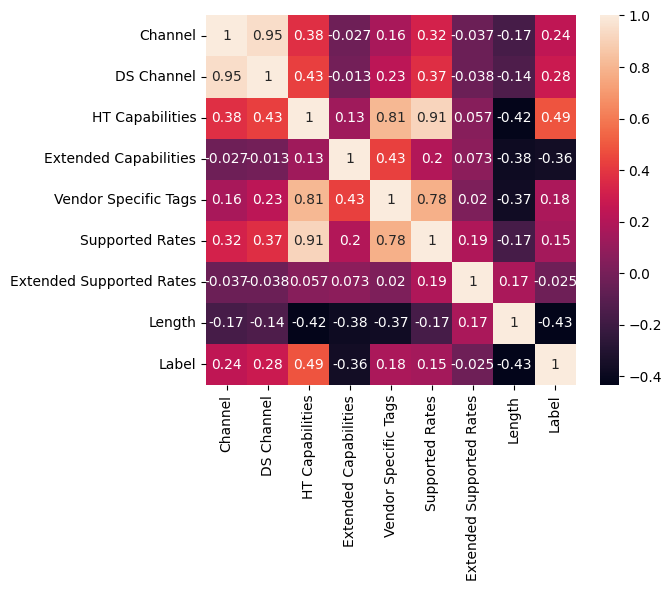

In [23]:
# calculating the correlation of each column with Label column and others
corr = correlation_dataset.corr()
sns.heatmap(corr, annot=True, square=True)

Based on the correlation between the Label and other features, these features appear to be more correlated with it (positively or negatively):
- Channel
- DS Channel
- HT Capabilities
- Extended Capabilities
- Length

### 5. Mutual Information
Leverage mutual information to identify shared information between the "Label" column and other columns.

In [24]:
X_train = cleaned_dataset[features_to_keep].copy()
y_train = cleaned_dataset['Label'].copy()
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)
display(mutual_info)

Channel                     0.198681
DS Channel                  0.423756
HT Capabilities             1.120834
Extended Capabilities       1.011670
Vendor Specific Tags        0.945972
Supported Rates             0.580722
Extended Supported Rates    0.033026
Length                      1.526901
dtype: float64

Based on the mutual information between the Label and other features, the following features seem to have higher mutual information with it:
- HT Capabilities
- Extended Capabilities
- Vendor Specific Tags
- Supported Rates
- Length

### 6. Crosstab Heatmap

In [25]:
def plot_heatmap(df, features, colormap="Blues"):
  sns.set_theme(style="whitegrid", font_scale=1)
  fig, axes = plt.subplots(2, 4, figsize=(30, 10))

  for i, axis in enumerate(axes.flat):
    crosstab = pd.crosstab(df['Label'], df[features[i]])
    sns.heatmap(crosstab, annot=True, fmt="d", cmap=colormap, ax=axis)
    axis.set_title(features[i])
    axis.set_xlabel(features[i])
    axis.set_ylabel('Label')

  plt.tight_layout()
  plt.show()

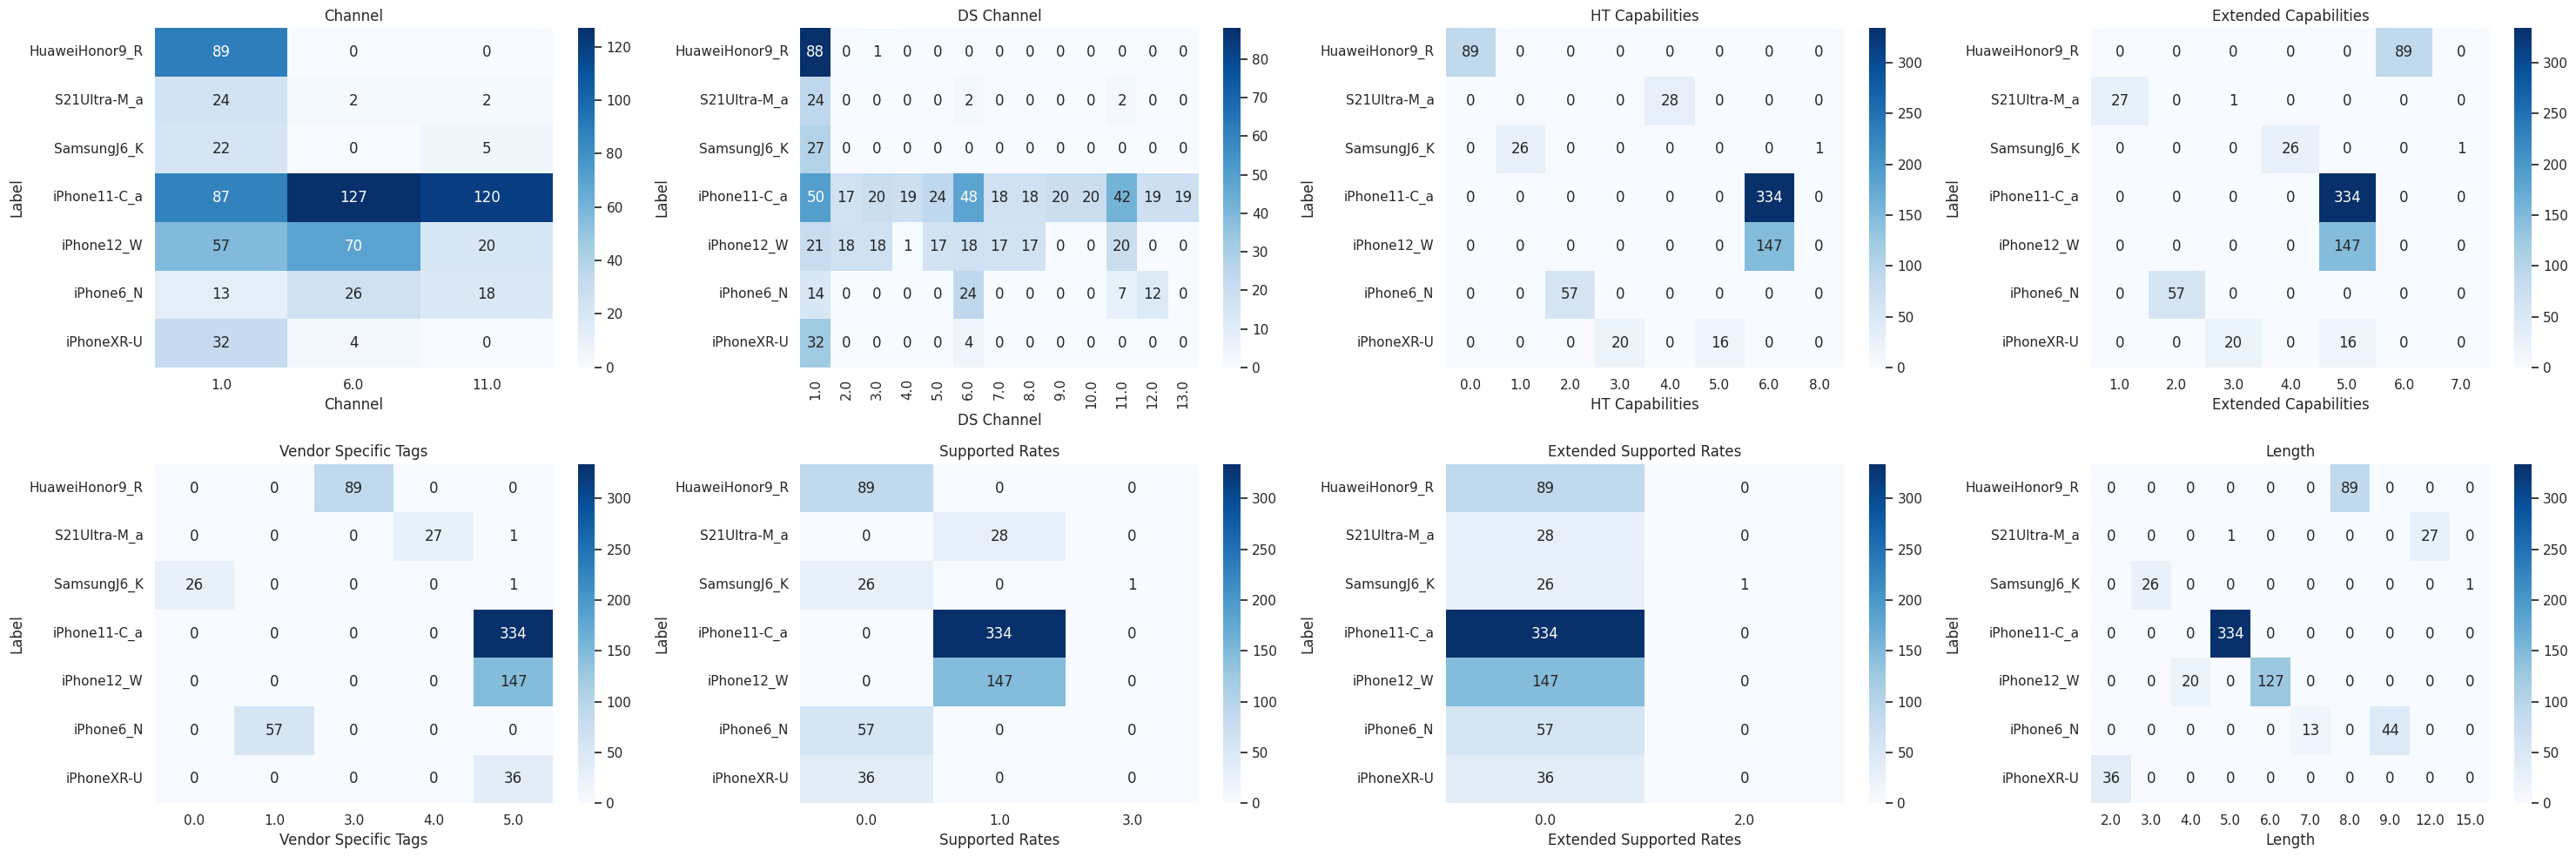

In [26]:
plot_heatmap(cleaned_dataset, features_to_keep)

Based on the heatmaps of crosstab between the Label and other features, these features seem to be related to Label:
- HT Capabilities
- Extended Capabilities
- Length

### 7. Gready search

In [27]:
feature_combinations = []

# all combination of features
for i in range(1, len(features_to_keep)+1):
    feature_combinations.extend(itertools.combinations(features_to_keep, i))

gs_performance_df = pd.DataFrame({}, index=['Homogeneous', 'Completeness', 'V_measure', '#Clusters', '#Labels', 'Error'])

gs_df = cleaned_dataset.copy()

for index, item in enumerate(feature_combinations):
  selected_features = list(item)
  # groupby seleceted features and assign a id to them
  gs_df[f"Cluster_{index}"] = gs_df.groupby(selected_features).ngroup()
  result = homogeneity_completeness_v_measure(gs_df["Label"], gs_df[f"Cluster_{index}"])
  num_clusters = len(np.unique(gs_df[f"Cluster_{index}"]))
  num_labels = len(np.unique(gs_df["Label"]))
  error = num_clusters - num_labels
  gs_performance_df[f'Cluster_{index}'] = list(result) + [num_clusters, num_labels, error]

<ipython-input-27-2b82a35d8d69>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gs_df[f"Cluster_{index}"] = gs_df.groupby(selected_features).ngroup()
<ipython-input-27-2b82a35d8d69>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gs_df[f"Cluster_{index}"] = gs_df.groupby(selected_features).ngroup()
<ipython-input-27-2b82a35d8d69>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

In [28]:
best_clusters = gs_performance_df[gs_performance_df.columns[(gs_performance_df.loc['Error'] == 0) | (gs_performance_df.loc['Error'] == 1)]]
best_clusters

,Cluster_2,Cluster_3,Cluster_12,Cluster_23,Cluster_24,Cluster_26,Cluster_28,Cluster_30,Cluster_54,Cluster_79,Cluster_83,Cluster_88
Homogeneous,0.732336,0.664772,0.484023,0.732336,0.732336,0.664772,0.664772,0.725847,0.484023,0.732336,0.664772,0.725847
Completeness,0.965429,0.956649,0.466338,0.965429,0.965429,0.956649,0.956649,0.989413,0.466338,0.965429,0.956649,0.989413
V_measure,0.832881,0.784440,0.475016,0.832881,0.832881,0.784440,0.784440,0.837381,0.475016,0.832881,0.784440,0.837381
#Clusters,8.000000,7.000000,7.000000,8.000000,8.000000,7.000000,7.000000,7.000000,7.000000,8.000000,7.000000,7.000000
#Labels,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
Error,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


In [29]:
best_clusters_features = dict()
for col in best_clusters.columns:
  cluster_id = int(col.split('_')[1])
  best_clusters_features[cluster_id] = list(feature_combinations[cluster_id])

best_clusters_features

{2: ['HT Capabilities'],
 3: ['Extended Capabilities'],
 12: ['Channel', 'Supported Rates'],
 23: ['HT Capabilities', 'Supported Rates'],
 24: ['HT Capabilities', 'Extended Supported Rates'],
 26: ['Extended Capabilities', 'Vendor Specific Tags'],
 28: ['Extended Capabilities', 'Extended Supported Rates'],
 30: ['Vendor Specific Tags', 'Supported Rates'],
 54: ['Channel', 'Supported Rates', 'Extended Supported Rates'],
 79: ['HT Capabilities', 'Supported Rates', 'Extended Supported Rates'],
 83: ['Extended Capabilities',
  'Vendor Specific Tags',
  'Extended Supported Rates'],
 88: ['Vendor Specific Tags', 'Supported Rates', 'Extended Supported Rates']}

## Train





In [30]:
# evaluating the performance on the training data
def train_performance_evaluator(selected_features):
  train_df = cleaned_dataset.copy()
  train_df['Cluster_ID'] = train_df.groupby(selected_features).ngroup()
  homogeneous, completeness, V_measure = homogeneity_completeness_v_measure(train_df["Label"], train_df["Cluster_ID"])
  num_clusters = len(np.unique(train_df["Cluster_ID"]))
  num_labels = len(np.unique(train_df["Label"]))
  error = num_clusters - num_labels
  train_performance_df = pd.DataFrame({'train_dataset':[homogeneous, completeness, V_measure, num_clusters, num_labels, error]},
                                        index=['Homogeneous', 'Completeness', 'V_measure', '#Clusters', '#Labels', 'Error'])

  return train_performance_df

In [31]:
train_total_df = pd.DataFrame({})

for cluster_id, features in best_clusters_features.items():
  train_performance_df = train_performance_evaluator(features)
  train_total_df = pd.concat([train_total_df, train_performance_df], axis=1)

train_total_df.columns = [f"Cluster_{id}" for id in best_clusters_features.keys()]
display(train_total_df)

,Cluster_2,Cluster_3,Cluster_12,Cluster_23,Cluster_24,Cluster_26,Cluster_28,Cluster_30,Cluster_54,Cluster_79,Cluster_83,Cluster_88
Homogeneous,0.732336,0.664772,0.484023,0.732336,0.732336,0.664772,0.664772,0.725847,0.484023,0.732336,0.664772,0.725847
Completeness,0.965429,0.956649,0.466338,0.965429,0.965429,0.956649,0.956649,0.989413,0.466338,0.965429,0.956649,0.989413
V_measure,0.832881,0.784440,0.475016,0.832881,0.832881,0.784440,0.784440,0.837381,0.475016,0.832881,0.784440,0.837381
#Clusters,8.000000,7.000000,7.000000,8.000000,8.000000,7.000000,7.000000,7.000000,7.000000,8.000000,7.000000,7.000000
#Labels,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
Error,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


## Validation

### Load and prepare dataset

In [32]:
def load_k_device_dataset(k):
  path = './challenge-dataset'
  df_list = list()

  for root, dirs, files in os.walk(path):
    files = random.sample(files, k)
    for file in enumerate(files):
      if file[1].endswith(".csv"):
        file_path = os.path.join(root, file[1])
        df = pd.read_csv(file_path)
        df_list.append(df)

  val_dataset = pd.concat(df_list, ignore_index=True)
  val_dataset['Timestamp'] = pd.to_datetime(val_dataset['Timestamp'], unit='s')
  return val_dataset

In [33]:
def create_5_val_dataset(k, val_dataset):
  if k == 6:
    os.mkdir(f"./testing_dataset/K={k}")
    dataset = val_dataset.copy()
    dataset.to_csv(f"./testing_dataset/K={k}/test_1.csv", index=False)
  else:
    os.mkdir(f"./testing_dataset/K={k}")
    dataset = val_dataset.copy()
    # shuffle the dataset
    shuffled_dataset = dataset.sample(frac=1).reset_index(drop=True)
    # size of each file
    file_size = len(dataset) // 5
    # Create five test datasets
    for i in range(5):
        start_idx = i * file_size
        if i == 4:
          end_idx = None
        else:
          end_idx = (i + 1) * file_size
        val_dataset = shuffled_dataset.iloc[start_idx:end_idx]
        val_dataset.to_csv(f"./testing_dataset/K={k}/test_{i + 1}.csv", index=False)

In [34]:
os.mkdir(f"./testing_dataset")
for k in range(2, 7):
  print("K =", k)
  val_dataset = load_k_device_dataset(k)
  create_5_val_dataset(k, val_dataset)

K = 2
K = 3
K = 4
K = 5
K = 6


In [35]:
def validation_performance_evaluator(selected_features):
  val_performance_df = pd.DataFrame({}, index=['Homogeneous', 'Completeness', 'V_measure', '#Clusters', '#Labels', 'Error'])

  for k in range(2, 7):
    path = f'./testing_dataset/K={k}'
    df_list = list()

    for root, dirs, files in os.walk(path):
      files = sorted(files)
      for file in enumerate(files):
        if file[1].endswith(".csv"):
          file_path = os.path.join(root,file[1])
          val_df = pd.read_csv(file_path)
          # dropping unneccessary columns like training
          val_df.drop(['SSID', 'VHT Capabilities', 'HE Capabilities'], axis=1, inplace=True)
          # label encoding columns like training
          encoded_val_df = encoder(val_df, features_to_keep)
          encoded_val_df['Cluster_ID'] = encoded_val_df.groupby(selected_features).ngroup()

          result = homogeneity_completeness_v_measure(encoded_val_df["Label"], encoded_val_df[f"Cluster_ID"])
          num_clusters = len(np.unique(encoded_val_df["Cluster_ID"]))
          num_labels = len(np.unique(encoded_val_df["Label"]))
          error = num_clusters - num_labels

          id = int(file[1].split('_')[-1].split('.')[0])
          val_performance_df[f'K{k}_test{id}'] = list(result) + [num_clusters, num_labels, error]

  # Create average performance
  val_avg_performance_df = pd.DataFrame({}, index=['Avg_Homogeneous', 'Avg_Completeness', 'Avg_V_measure', 'Avg_Error'])
  k = 2
  for i in range(0, 16, 5):
    val_avg_performance_df[f'K={k}'] = 0
    val_avg_performance_df[f'K={k}'].iloc[0] = val_performance_df.loc['Homogeneous'][i:i+5].mean()
    val_avg_performance_df[f'K={k}'].iloc[1] = val_performance_df.loc['Completeness'][i:i+5].mean()
    val_avg_performance_df[f'K={k}'].iloc[2] = val_performance_df.loc['V_measure'][i:i+5].mean()
    val_avg_performance_df[f'K={k}'].iloc[3] = val_performance_df.loc['Error'][i:i+5].mean()
    k +=1
  # k=6
  val_avg_performance_df[f'K=6'] = val_performance_df['K6_test1'].values[[0, 1, 2, 5]]
  val_avg_performance_df['Avg_Ks'] = [val_avg_performance_df[:].iloc[i].mean() for i in range(4)]

  return val_performance_df, val_avg_performance_df

In [36]:
def validation_performance_plotter(val_avg_performance_df):
  df = val_avg_performance_df.iloc[:-1, :-1]

  k = [2, 3, 4, 5, 6]
  for index, row in df.iterrows():
      plt.plot(k, row, label=index)

  plt.xlabel('K')
  plt.ylabel('Values')
  plt.xticks(k)
  plt.legend()
  plt.show()

  plt.plot(k, val_avg_performance_df.iloc[-1, :-1], label="Avg_Error")
  plt.xlabel('K')
  plt.ylabel('Values')
  plt.xticks(k)
  plt.legend()
  plt.show()

### Plot average performance

<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[0] = val_performance_df.loc['Homogeneous'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[1] = val_performance_df.loc['Completeness'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  va

Cluster_ID: 2, Features: ['HT Capabilities']


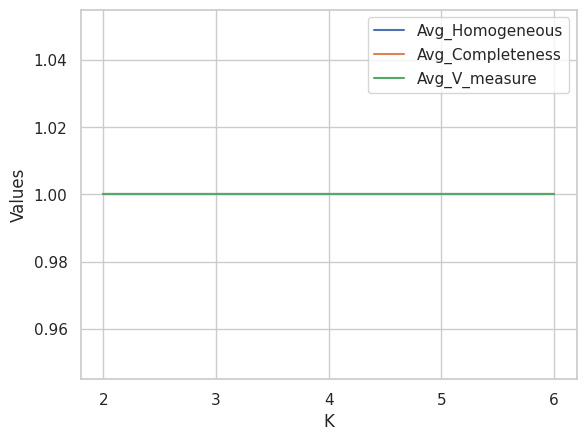

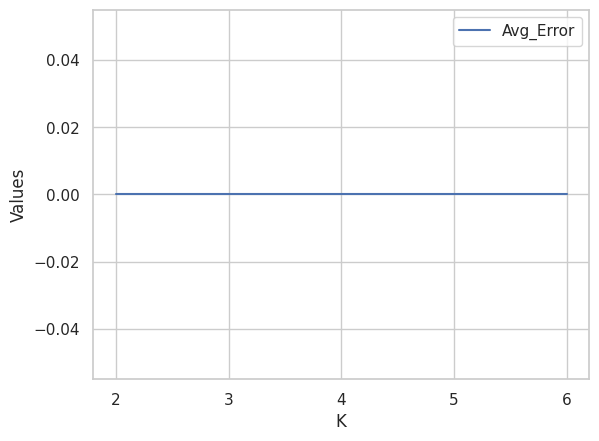

<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[0] = val_performance_df.loc['Homogeneous'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[1] = val_performance_df.loc['Completeness'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  va

Cluster_ID: 3, Features: ['Extended Capabilities']


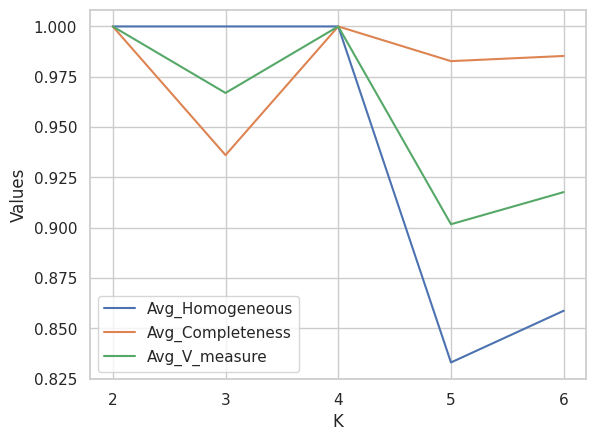

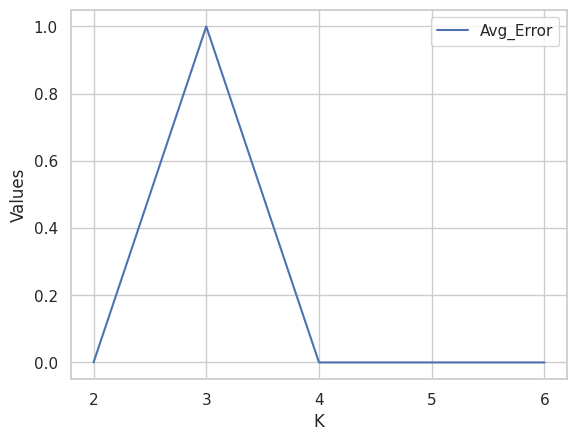

<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[0] = val_performance_df.loc['Homogeneous'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[0] = val_performance_df.loc['Homogeneous'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val

Cluster_ID: 12, Features: ['Channel', 'Supported Rates']


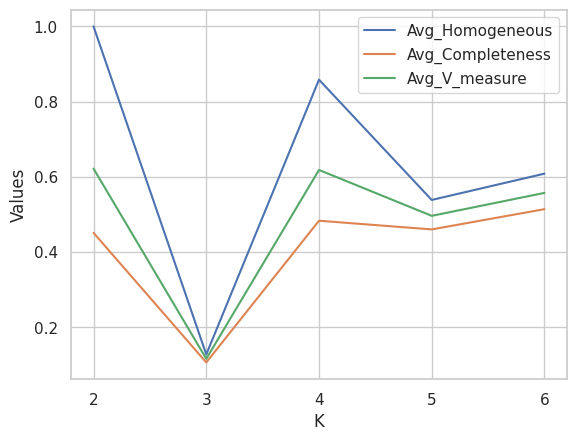

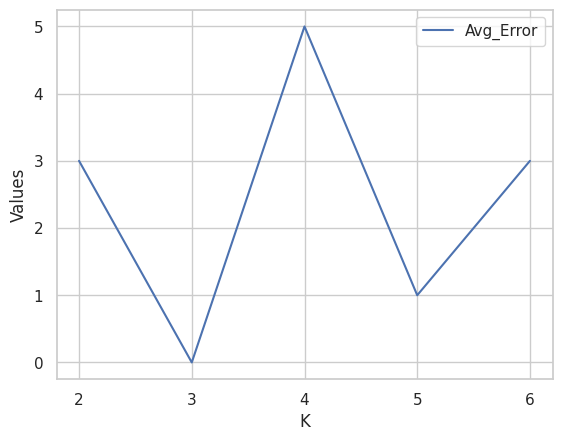

<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[0] = val_performance_df.loc['Homogeneous'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[1] = val_performance_df.loc['Completeness'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  va

Cluster_ID: 23, Features: ['HT Capabilities', 'Supported Rates']


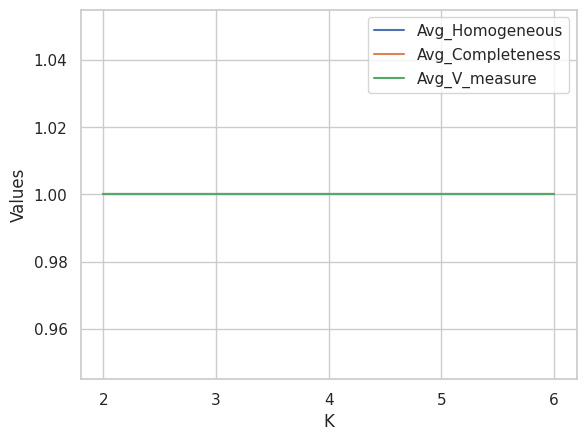

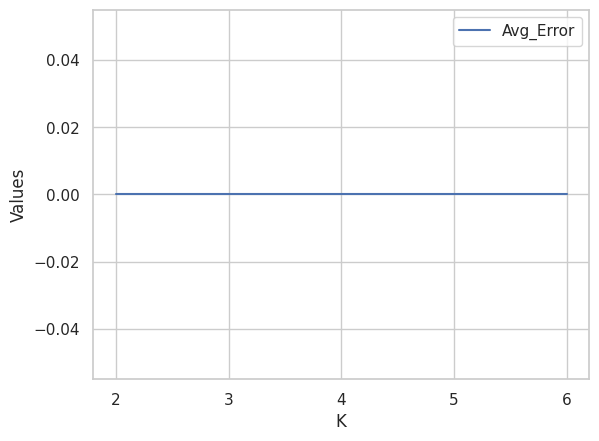

<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[0] = val_performance_df.loc['Homogeneous'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[1] = val_performance_df.loc['Completeness'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  va

Cluster_ID: 24, Features: ['HT Capabilities', 'Extended Supported Rates']


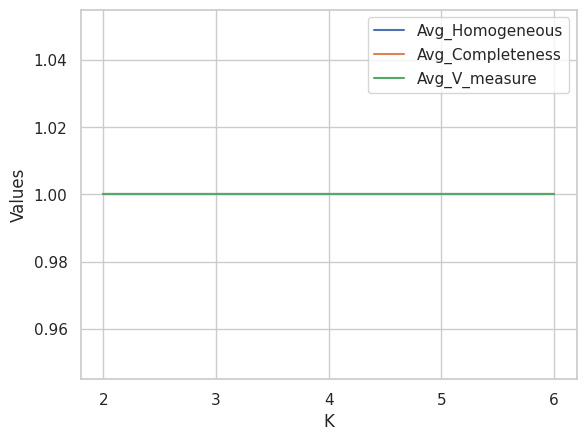

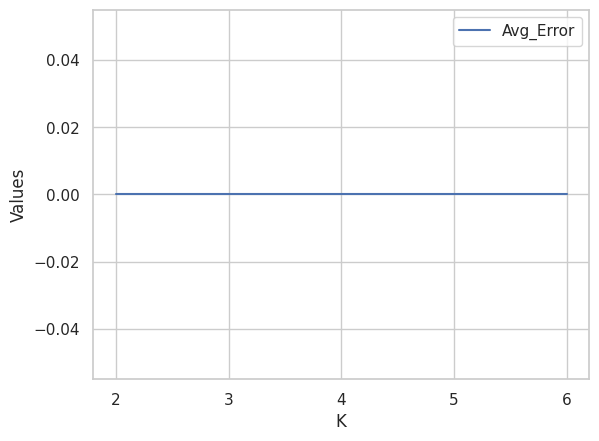

<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[0] = val_performance_df.loc['Homogeneous'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[1] = val_performance_df.loc['Completeness'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  va

Cluster_ID: 26, Features: ['Extended Capabilities', 'Vendor Specific Tags']


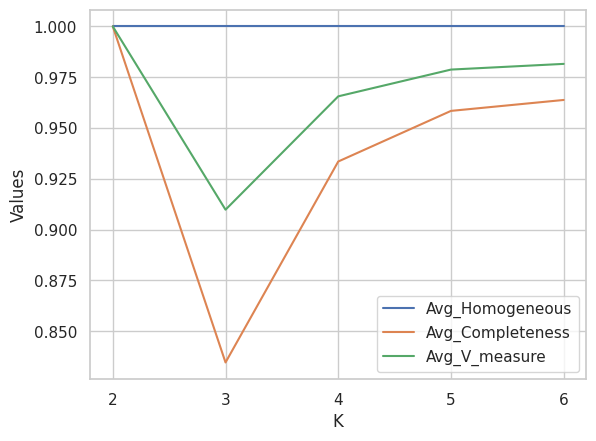

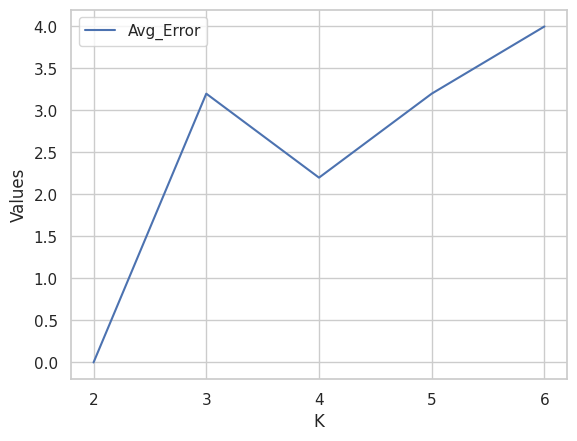

<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[0] = val_performance_df.loc['Homogeneous'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[1] = val_performance_df.loc['Completeness'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  va

Cluster_ID: 28, Features: ['Extended Capabilities', 'Extended Supported Rates']


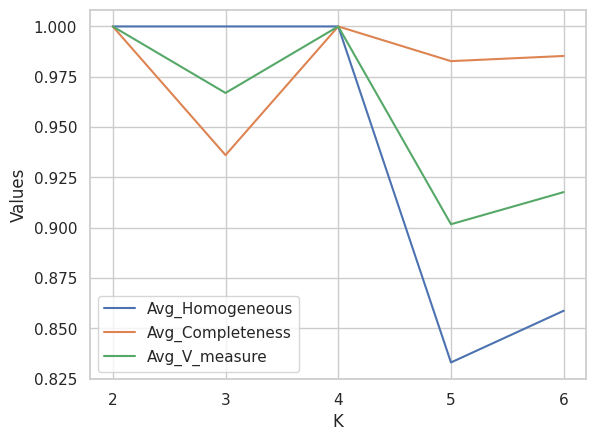

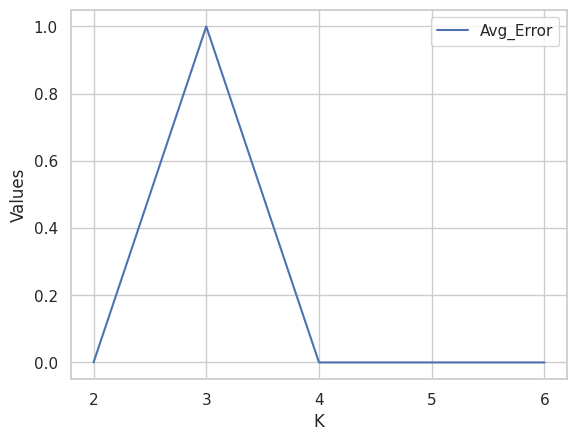

<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[0] = val_performance_df.loc['Homogeneous'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[1] = val_performance_df.loc['Completeness'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  va

Cluster_ID: 30, Features: ['Vendor Specific Tags', 'Supported Rates']


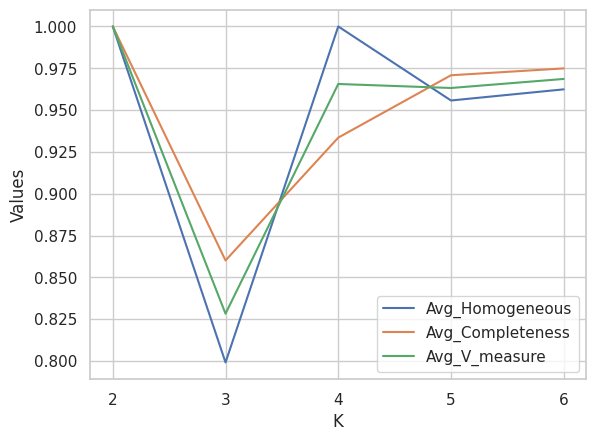

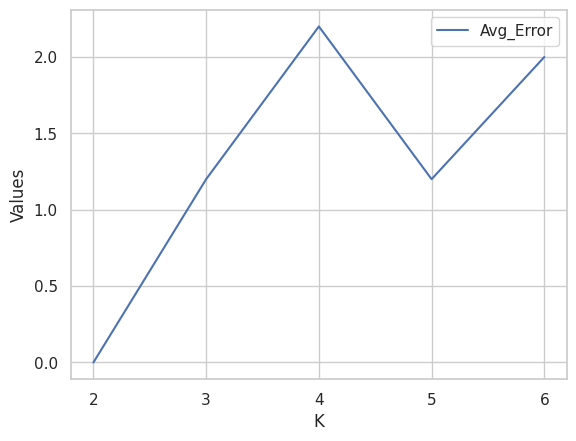

<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[0] = val_performance_df.loc['Homogeneous'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[0] = val_performance_df.loc['Homogeneous'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val

Cluster_ID: 54, Features: ['Channel', 'Supported Rates', 'Extended Supported Rates']


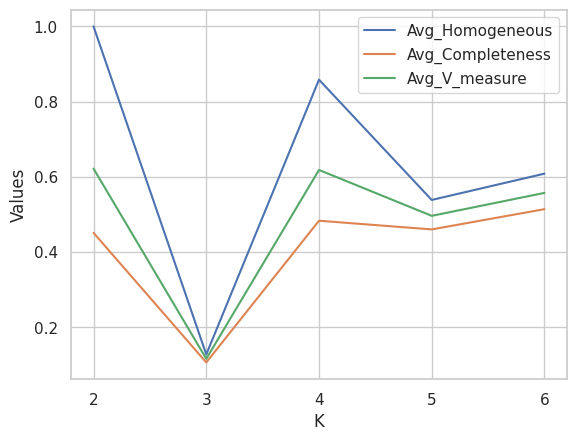

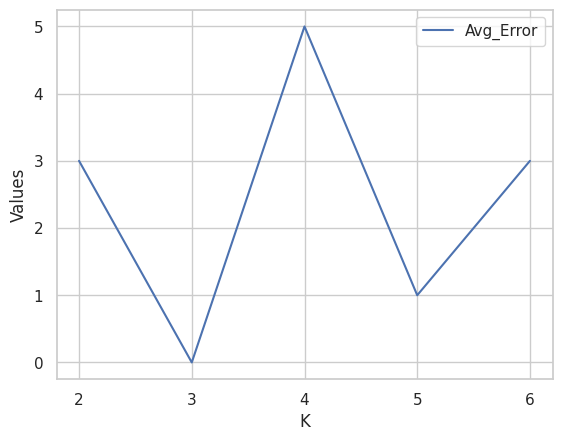

<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[0] = val_performance_df.loc['Homogeneous'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[1] = val_performance_df.loc['Completeness'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  va

Cluster_ID: 79, Features: ['HT Capabilities', 'Supported Rates', 'Extended Supported Rates']


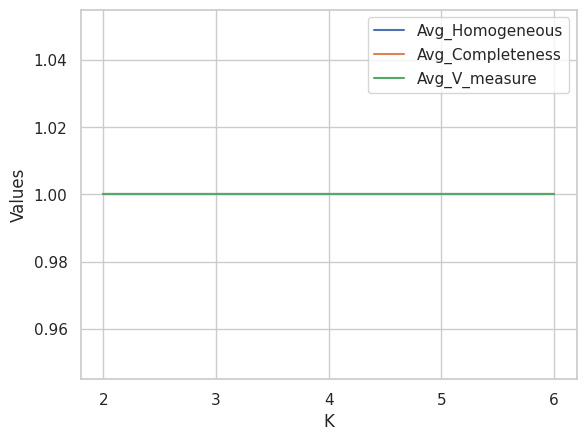

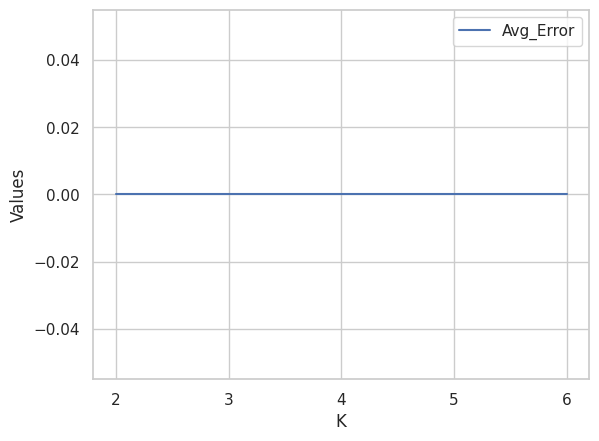

<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[0] = val_performance_df.loc['Homogeneous'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[1] = val_performance_df.loc['Completeness'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  va

Cluster_ID: 83, Features: ['Extended Capabilities', 'Vendor Specific Tags', 'Extended Supported Rates']


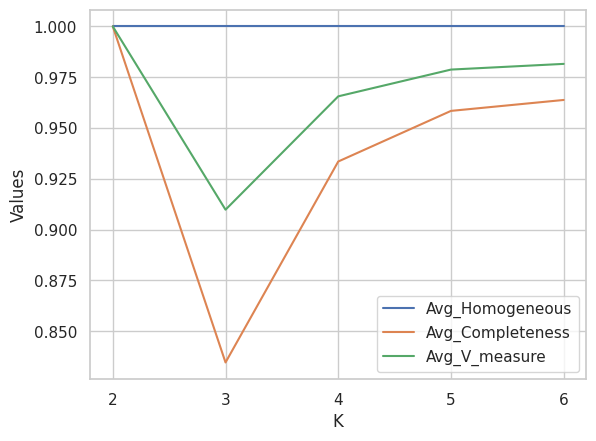

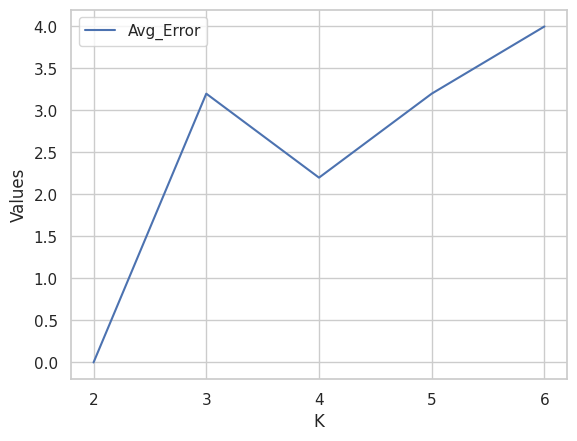

<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[0] = val_performance_df.loc['Homogeneous'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_avg_performance_df[f'K={k}'].iloc[1] = val_performance_df.loc['Completeness'][i:i+5].mean()
<ipython-input-35-12415d9f72ff>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  va

Cluster_ID: 88, Features: ['Vendor Specific Tags', 'Supported Rates', 'Extended Supported Rates']


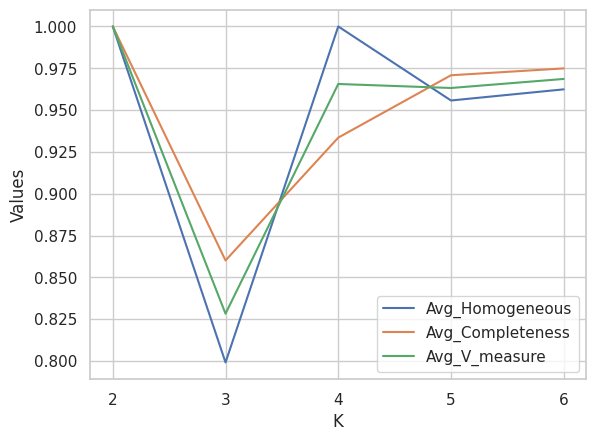

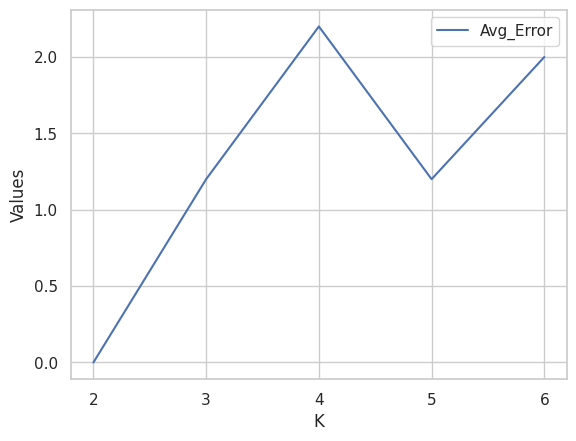

,Cluster_2,Cluster_3,Cluster_12,Cluster_23,Cluster_24,Cluster_26,Cluster_28,Cluster_30,Cluster_54,Cluster_79,Cluster_83,Cluster_88
Avg_Homogeneous,1.0,0.938375,0.626750,1.0,1.0,1.000000,0.938375,0.943445,0.626750,1.0,1.000000,0.943445
Avg_Completeness,1.0,0.980840,0.403214,1.0,1.0,0.938074,0.980840,0.947866,0.403214,1.0,0.938074,0.947866
Avg_V_measure,1.0,0.957288,0.482134,1.0,1.0,0.967148,0.957288,0.945136,0.482134,1.0,0.967148,0.945136
Avg_Error,0.0,0.200000,2.400000,0.0,0.0,2.520000,0.200000,1.320000,2.400000,0.0,2.520000,1.320000


In [37]:
val_total_df = pd.DataFrame({})

for cluster_id, features in best_clusters_features.items():
  val_performance_df, val_avg_performance_df = validation_performance_evaluator(features)
  print(f"Cluster_ID: {cluster_id}, Features: {features}")
  validation_performance_plotter(val_avg_performance_df)
  val_total_df = pd.concat([val_total_df, val_avg_performance_df['Avg_Ks']], axis=1)

val_total_df.columns = [f"Cluster_{id}" for id in best_clusters_features.keys()]
display(val_total_df)

In [38]:
selected_best_clusters_features = {id: best_clusters_features[id] for id in [2, 3, 23, 24, 28, 79]}
selected_best_clusters_features

{2: ['HT Capabilities'],
 3: ['Extended Capabilities'],
 23: ['HT Capabilities', 'Supported Rates'],
 24: ['HT Capabilities', 'Extended Supported Rates'],
 28: ['Extended Capabilities', 'Extended Supported Rates'],
 79: ['HT Capabilities', 'Supported Rates', 'Extended Supported Rates']}

## 8. Unlabeled Datasest

### Load dataset

In [43]:
test_dataset = pd.read_csv('/content/drive/MyDrive/MAC-Random/MAC_derand_unlabelled-challenge.csv')

grouped_test_dataset = test_dataset.groupby(['MAC Address'])
grouped_test_dataset = grouped_test_dataset.first().reset_index()
display(grouped_test_dataset)

,MAC Address,Timestamp,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,SSID,Supported Rates,Extended Supported Rates,VHT Capabilities,HE Capabilities,Length
0,02:02:70:30:b6:43,1.625073e+09,1,3.0,2d401bff00000000000000000000000000000000000000...,0000080400000040,None,None,82848b96,0c1218243048606c,None,23010808180080203002000d009f08000000fdfffdff39...,143
1,02:0b:5b:9e:41:54,1.623904e+09,1,2.0,631117ffff000000000000000000000000000000000000...,0000088001400040,00904c0408bf0c3230900ffaff0000faff0000,None,02040b16,0c1218243048606c,None,None,154
2,02:0b:72:cb:7d:eb,1.623851e+09,11,9.0,631117ffff000000000000000000000000000000000000...,0000088001400040,00904c0408bf0c3230900ffaff0000faff0000,None,02040b16,0c1218243048606c,None,None,154
3,02:0c:01:7e:50:d6,1.623850e+09,11,13.0,631117ffff000000000000000000000000000000000000...,0000088001400040,00904c0408bf0c3230900ffaff0000faff0000,None,02040b16,0c1218243048606c,None,None,154
4,02:11:33:61:b5:ef,1.625073e+09,1,2.0,2d401bff00000000000000000000000000000000000000...,0000080400000040,None,None,82848b96,0c1218243048606c,None,23010808180080203002000d009f08000000fdfffdff39...,143
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,fe:c5:50:16:eb:8c,1.625074e+09,11,11.0,2d401bff00000000000000000000000000000000000000...,0000080400000040,None,None,82848b96,0c1218243048606c,None,23010808180080203002000d009f08000000fdfffdff39...,131
1497,fe:ed:a5:45:e8:b9,1.626773e+09,11,11.0,ad0113ffff000000000000000000000000000000000000...,04000a82004000408001,0050f208002700,None,02040b16,0c1218243048606c,92f99133faff6203faff6203,02001f,143
1498,fe:f5:97:dd:58:86,1.625076e+09,6,8.0,2d401bff00000000000000000000000000000000000000...,0000080400000040,None,None,82848b96,0c1218243048606c,None,23010808180080203002000d009f08000000fdfffdff39...,143
1499,fe:f9:ac:47:0d:b7,1.625073e+09,11,11.0,2d401bff00000000000000000000000000000000000000...,0000080400000040,None,None,82848b96,0c1218243048606c,None,23010808180080203002000d009f08000000fdfffdff39...,131


### Prediction


In [45]:
predicted_devices_per_cluster = {}
for cluster_id, features in selected_best_clusters_features.items():
  test_df = grouped_test_dataset.copy()
  test_df[cluster_id] = test_df.groupby(features).ngroup()
  predicted_devices_per_cluster[cluster_id] = len(np.unique(test_df[cluster_id]))

predicted_devices_per_cluster

{2: 7, 3: 8, 23: 8, 24: 7, 28: 8, 79: 8}

In [46]:
for cluster_id, num_devices in predicted_devices_per_cluster.items():
  print(f'Cluster ID: {cluster_id}, Features: {selected_best_clusters_features[cluster_id]}, Number of Predicted devices: {num_devices}')

Cluster ID: 2, Features: ['HT Capabilities'], Number of Predicted devices: 7
Cluster ID: 3, Features: ['Extended Capabilities'], Number of Predicted devices: 8
Cluster ID: 23, Features: ['HT Capabilities', 'Supported Rates'], Number of Predicted devices: 8
Cluster ID: 24, Features: ['HT Capabilities', 'Extended Supported Rates'], Number of Predicted devices: 7
Cluster ID: 28, Features: ['Extended Capabilities', 'Extended Supported Rates'], Number of Predicted devices: 8
Cluster ID: 79, Features: ['HT Capabilities', 'Supported Rates', 'Extended Supported Rates'], Number of Predicted devices: 8


## 9. Conclusion

The **cluster_79**, including of **['HT Capabilities', 'Supported Rates', 'Extended Supported Rates']** features gave us the best result both in training part and validation part by looking at **Homogeneous,completeness, V_measure and Error** metrics. Here, you can see it results on training vs validation part.

```
Training part                 Validation part
=====================================================
Homogeneous     0.732336      Ave_Homogeneous     1.0
completeness    0.965429      Ave_completeness    1.0
V_measure       0.832881      Ave_V_measure       1.0
Error           1.000000      Ave_Error           0.0                            
```





We assessed feature significance via correlation matrix, mutual information, heatmap visualization, and Greedy search techniques. Greedy Search yielded optimal feature combinations, forming our primary clusters.





In addition to identifying the optimal cluster combination, we opted for employing max voting with the top 5 clusters to enhance result reliability.

For predicting the number of devices:


```
Cluster_23 predicts 8 devices on test dataset
Cluster_24 predicts 7 devices on test dataset
Cluster_28 predicts 8 devices on test dataset
Cluster_30 predicts 6 devices on test dataset
Cluster_79 predicts 8 devices on test dataset
Cluster_88 predicts 6 devices on test dataset
```
which we decided to use max voting and choose 8 as the last result